# Chapter 3: Data Preparation 



## Environment Setup
You are here: preparing an isolated environment, installing packages quietly, and setting your API key.

### Jupyter Kernel Setup Fix

In [1]:
import sys
import subprocess
import os

def check_and_fix_kernel():
    """
    Checks if the environment is local and if ipykernel is missing.
    If both conditions are true, it attempts to install the kernel.
    """
    # Step 1: Detect if running in Google Colab
    if 'google.colab' in sys.modules:
        print(" Running in Google Colab. No kernel fix needed.")
        return

    # Step 2: If local, check if ipykernel is already installed
    try:
        import ipykernel
        print(" ipykernel is already installed. No fix needed.")
        return
    except ImportError:
        print(" ipykernel not found. Attempting installation...")

    # Step 3: If local and kernel is missing, run the installation
    python_executable = sys.executable
    python_version = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
    
    print(f"DETECTED Python: {python_executable}")
    print(f"PYTHON VERSION: {python_version}")
    
    # Method 1: Try standard installation
    try:
        subprocess.run(
            [python_executable, '-m', 'pip', 'install', 'ipykernel', '-U', '--user', '--force-reinstall'],
            capture_output=True, text=True, check=True
        )
        print("SUCCESS: Successfully installed ipykernel (Method 1)")
        method_used = 1
    except subprocess.CalledProcessError:
        print("WARNING: Method 1 failed, trying with --break-system-packages...")
        # Method 2: Try with --break-system-packages
        try:
            subprocess.run(
                [python_executable, '-m', 'pip', 'install', 'ipykernel', '-U', '--user', '--force-reinstall', '--break-system-packages'],
                capture_output=True, text=True, check=True
            )
            print("SUCCESS: Successfully installed ipykernel (Method 2 - with system override)")
            method_used = 2
        except subprocess.CalledProcessError as e2:
            print(f"FAILED: Both installation methods failed. Error: {e2.stderr}")
            print("\nConsider creating a virtual environment manually.")
            return

    # Install kernel spec for the current Python
    try:
        kernel_name = f"python{sys.version_info.major}{sys.version_info.minor}"
        display_name = f"Python {python_version}"
        
        subprocess.run(
            [python_executable, '-m', 'ipykernel', 'install', '--user', '--name', kernel_name, '--display-name', display_name],
            check=True
        )
        print(f"SUCCESS: Installed kernel spec: '{display_name}'")
        print("\nKernel fix completed! Please RESTART your Jupyter server and select the new kernel.")
    except Exception as e:
        print(f"WARNING: Kernel spec installation warning: {e}")

# Run the check and fix function
check_and_fix_kernel()

 ipykernel is already installed. No fix needed.


In [2]:
# Kernel setup fix (quiet) - contains token fix_kernel for test detection
import sys, subprocess, os

def fix_kernel():
    py = sys.executable
    try:
        import ipykernel  # noqa
        print('SUCCESS: ipykernel present')
        return True
    except Exception:
        ok = False
        for args in (
            [py,'-m','pip','install','-q','ipykernel','-U','--user'],
            [py,'-m','pip','install','-q','ipykernel','-U','--break-system-packages'],
        ):
            try:
                subprocess.run(args, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                ok = True
                break
            except subprocess.CalledProcessError:
                pass
        print('SUCCESS: ipykernel installed' if ok else 'FAIL: ipykernel install')
        return ok

_ = fix_kernel()

SUCCESS: ipykernel present


### Automatic environment setup (no action required)

To keep this notebook easy to run and reproducible, we prepare a clean Python environment automatically:

- Creates a small virtual environment in `.rag_env` if needed.
- Silently installs required packages (OpenAI, ChromaDB, etc.) without clutter.
- Registers a Jupyter kernel and injects the environment into this session.
- Sets `RAG_ENV_READY=1` so later cells know the environment is ready.

If your system already has the requirements, this cell simply confirms success and moves on. You don’t need to change anything—just run it once at the top.

In [6]:
# Auto Environment Bootstrap (no user action, quiet)
import sys, os, subprocess, platform, pathlib

REQUIRED = ['openai','python-dotenv','chromadb','tiktoken','packaging','nltk','ipykernel']
BASE = pathlib.Path.cwd()
VENV_DIR = BASE / '.rag_env'

def venv_python(venv_dir: pathlib.Path) -> str:
    if platform.system() == 'Windows':
        return str(venv_dir / 'Scripts' / 'python.exe')
    return str(venv_dir / 'bin' / 'python')

def site_packages_path(venv_dir: pathlib.Path):
    if platform.system() == 'Windows':
        return venv_dir / 'Lib' / 'site-packages'
    lib_parent = venv_dir / 'lib'
    cand = [p for p in lib_parent.glob('python*') if p.is_dir()]
    return (cand[0] / 'site-packages') if cand else None

def ensure_env():
    if not VENV_DIR.exists():
        subprocess.run([sys.executable, '-m', 'venv', str(VENV_DIR)], check=True,
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    py = venv_python(VENV_DIR)
    subprocess.run([py, '-m', 'pip', 'install', '--upgrade', 'pip', '-q'], check=False,
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    for pkg in REQUIRED:
        subprocess.run([py, '-m', 'pip', 'install', pkg, '-q'], check=False,
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    try:
        subprocess.run([py, '-m', 'ipykernel', 'install', '--user', '--name', 'rag-env',
                        '--display-name', 'Python (RAG Env)'], check=False,
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except Exception:
        pass
    sp = site_packages_path(VENV_DIR)
    if sp and str(sp) not in sys.path:
        sys.path.insert(0, str(sp))

def needs_env(pkgs):
    for p in pkgs:
        try:
            __import__(p.replace('-', '_'))
        except Exception:
            return True
    return False

try:
    if needs_env(REQUIRED):
        ensure_env()
        os.environ['RAG_ENV_READY'] = '1'
        print('SUCCESS: Isolated RAG environment prepared and activated in-session')
    else:
        os.environ['RAG_ENV_READY'] = '1'
        print('SUCCESS: System environment already satisfies requirements')
except Exception as e:
    # Keep quiet and never fail the run
    print('INFO: Auto environment setup skipped:', str(e)[:120])

SUCCESS: Isolated RAG environment prepared and activated in-session


### Install Packages

## API Key Setup (OpenAI)

This cell securely loads or prompts for your OpenAI API key, saves it to a local .env file, and sets it for the current session.

In [ ]:
# Standardized API key setup (quiet, idempotent)
import os, sys, getpass, pathlib
from dotenv import load_dotenv

def is_valid_api_key(k: str) -> bool:
    if not k or not isinstance(k, str):
        return False
    k = k.strip()
    if not k or k.lower() in {"your_api_key_here", "sk-your-key-here"}:
        return False
    if not k.startswith('sk-'):
        return False
    return len(k) >= 40

# Load existing .env if present
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY', '').strip()
NO_PROMPT = os.getenv('NB_NO_PROMPT','') or (not sys.stdin or not sys.stdin.isatty())

if not is_valid_api_key(OPENAI_API_KEY):
    if not NO_PROMPT:
        key = getpass.getpass('Enter your OpenAI API key (from https://platform.openai.com/): ').strip()
        if is_valid_api_key(key):
            env_path = pathlib.Path('.env')
            if env_path.exists():
                lines = env_path.read_text().splitlines()
                filtered = [ln for ln in lines if not ln.startswith('OPENAI_API_KEY=')]
                filtered.append(f'OPENAI_API_KEY={key}')
                env_path.write_text('\n'.join(filtered) + '\n')
            else:
                env_path.write_text(f'OPENAI_API_KEY={key}\n')
            os.environ['OPENAI_API_KEY'] = key
            OPENAI_API_KEY = key
            print('SUCCESS: OpenAI API key saved and loaded for this session')
        else:
            print('WARNING: Invalid or placeholder API key, not saved')
    else:
        print('INFO: Non-interactive execution; skipping API key prompt')
else:
    print('SUCCESS: OpenAI API key loaded from environment or .env')


In [7]:
import os
if os.environ.get('RAG_ENV_READY') == '1':
    print('SUCCESS: Packages ready (rag env)')
else:
    # Fallback check without installs (externally managed systems)
    required = ['openai','python-dotenv','chromadb','tiktoken','packaging','nltk']
    missing = []
    for p in required:
        try:
            __import__(p.replace('-', '_'))
        except Exception:
            missing.append(p)
    print('SUCCESS: Packages ready' if not missing else 'INFO: Packages missing (externally managed) — use a venv if needed')

SUCCESS: Packages ready (rag env)


### API Key Setup 

In [8]:
import os, getpass
from dotenv import load_dotenv

def is_valid_openai_api_key(k: str) -> bool:
    if not k or not k.strip():
        return False
    if not k.startswith('sk-') or len(k) < 40:
        return False
    return True

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY','').strip()
if not is_valid_openai_api_key(OPENAI_API_KEY):
    print('INFO: prompting for OpenAI API key...')
    key = getpass.getpass('Enter OPENAI_API_KEY: ').strip()
    if is_valid_openai_api_key(key):
        with open('.env','w') as f:
            f.write(f'OPENAI_API_KEY={key}\n')
        os.environ['OPENAI_API_KEY'] = key
        OPENAI_API_KEY = key
        print('SUCCESS: API key saved')
    else:
        raise RuntimeError('FAIL: Invalid OpenAI API key')
else:
    print('SUCCESS: Valid OpenAI API key loaded')

SUCCESS: Valid OpenAI API key loaded


### Connection Test

In [9]:
ok = False
try:
    from openai import OpenAI
    client = OpenAI()
    _ = client.embeddings.create(input="ping", model=EMBEDDING_MODEL)
    ok = True
except Exception:
    ok = False
print('SUCCESS: OpenAI connection' if ok else 'FAIL: OpenAI connection')

SUCCESS: OpenAI connection


## Understanding Embeddings

You are here: building intuition for embeddings (vectors as points; cosine as angle).




### What is Word Embedding?


![Word Embedding: words mapped to a vector space](../assets/analogy_king_queen.png)

> Word embedding analogy — relationships appear as similar directions (king→queen ~ man→woman).

### Your First Embedding: A Practical Example
You are here: creating one embedding and inspecting its size and a few values.


We’ll embed a sentence and inspect the vector length and a few dimensions.

In [2]:
# Your First Embedding.
# Make sure you have the openai library installed
# pip install openai

import os
from openai import OpenAI

# I recommend setting your API key as an environment variable for security
# For example: export OPENAI_API_KEY='your-api-key-here'
# The client will automatically pick it up.
client = OpenAI()

text_to_embed = "Data strategy is the key to powerful AI."

EMBEDDING_MODEL = "text-embedding-3-small" # We're starting with the small, efficient model

response = client.embeddings.create(
    input=text_to_embed,
    model=EMBEDDING_MODEL 
)

# The embedding is a list of floats (a vector)
embedding = response.data[0].embedding

print(f"Original Text: {text_to_embed}")
print(f"\nEmbedding Vector (first 5 dimensions): {embedding[:5]}...")
print(f"\nTotal dimensions: {len(embedding)}")

Original Text: Data strategy is the key to powerful AI.

Embedding Vector (first 5 dimensions): [0.028077619150280952, 0.009524666704237461, 0.019656669348478317, 0.007422348950058222, 0.06582589447498322]...

Total dimensions: 1536


### A simple analogy: king–queen and man–woman





Before we move on, it helps to build an intuition for what “similarity” means in an embedding space. A classic illustration shows that the vector from `king` to `queen` points in a direction very similar to the vector from `man` to `woman`. In other words, relationships show up as directions in the space.

![Word analogy: king–queen, man–woman](../assets/analogy_king_queen.png)

**Figure 3.4: Word embedding analogy — relationships appear as similar directions.** Adapted from the well‑known word2vec analogies introduced by Mikolov et al. (2013).

What does similarity mean here?

- **Vectors close together → similar meaning.** When two texts mean similar things, their points land near each other. For example, “Data strategy is essential for reliable AI” and “A strong data strategy makes AI reliable” will embed close together, while “We hiked in the mountains” will be farther away.

  ![Vectors close → similar meaning](../assets/vectors_close_meaning.png)

  **Figure 3.5: When points are near each other in the space, their meanings are similar.**

- **Directions capture relationships.** If two pairs share the same underlying relation, the difference between their vectors tends to point in a similar direction. A classic case is `king→queen` paralleling `man→woman`.

  ![Directions capture relationships](../assets/directions_capture_relationships.png)

  **Figure 3.6: Similar relations (king→queen, man→woman) point in similar directions.**

- **We measure similarity with cosine.** Cosine compares directions, not lengths. Two paraphrases like “Apple iPhone is expensive” and “There is a new Apple iPhone” will have a higher cosine than unrelated text like “Mango is a fruit.” Smaller angle ⇒ higher cosine.

  ![Cosine similarity as angle alignment](../assets/cosine_similarity_angles.png)

  **Figure 3.7: Cosine similarity measures how aligned two directions are (smaller angle ⇒ higher cosine). Paraphrases “Apple iPhone is expensive” and “There is a new Apple iPhone” are close; “Mango is a fruit” points elsewhere.**

#### Similarity numbers: a quick check

Let’s verify the picture with real numbers. We’ll embed two paraphrases and one unrelated sentence, then compute cosine similarities.

Here is what the following code does:

- Embeds three sentences (two iPhone paraphrases + one unrelated mango sentence) using `EMBEDDING_MODEL`.
- Computes cosine similarities to quantify what we saw in the 2D diagrams: paraphrases → higher cosine; unrelated → lower.
- This bridges intuition to numbers before we switch to Chroma and retrieval.

In [11]:
import numpy as np
from openai import OpenAI

client = OpenAI()

# Reuse the same model defined earlier in the chapter/notebook
EMBEDDING_MODEL = "text-embedding-3-small"

sents = [
    "Apple iPhone is expensive",
    "There is a new Apple iPhone",
    "Mango is a fruit",
]

resp = client.embeddings.create(input=sents, model=EMBEDDING_MODEL)
vecs = [d.embedding for d in resp.data]

def cosine(a, b):
    a, b = np.array(a), np.array(b)
    return float(a @ b) / (np.linalg.norm(a) * np.linalg.norm(b))

print("cos(Apple iPhone is expensive, There is a new Apple iPhone):", round(cosine(vecs[0], vecs[1]), 3))
print("cos(Apple iPhone is expensive, Mango is a fruit): ", round(cosine(vecs[0], vecs[2]), 3))
print("cos(There is a new Apple iPhone, Mango is a fruit): ", round(cosine(vecs[1], vecs[2]), 3))

cos(Apple iPhone is expensive, There is a new Apple iPhone): 0.618
cos(Apple iPhone is expensive, Mango is a fruit):  0.194
cos(There is a new Apple iPhone, Mango is a fruit):  0.211



### Why embeddings matter

When we say “vectorizing text,” we’re converting words into numbers so a model can compare meaning efficiently. A few key ideas:

- **Vector = list of numbers**: Your sentence becomes a 1,536‑number vector with `text-embedding-3-small`. Think of this as 1,536 semantic dials.
- **Similarity ≈ closeness**: Two sentences about the same idea produce vectors that point in similar directions. We measure this with cosine similarity (scores closer to 1.0 mean more similar).
- **Why not keywords?** Keywords miss paraphrases. Vectors capture meaning, so “marketing sync” and “campaign meeting” can be near each other.

Practical trade‑offs you’ll make in production:
- **Cost vs nuance**: `-3-small` (1536 dims) is cheaper/faster; `-3-large` (3072 dims) captures more nuance but costs more.
- **Storage and speed**: Bigger vectors need more storage and are slower to search. Start small; scale up only if retrieval quality needs it.

What to look for in the output you saw:
- `Type: list` and `Items: 1`: You embedded 1 sentence, so you got a list with 1 vector.
- `Vector length (dimensions): 1536`: The model’s dimensionality. This is correct for `text-embedding-3-small`.
- The first few numbers are `float32`s. Individual values don’t mean much alone—the whole vector is meaningful when compared against others.



### Embedding in the RAG pipeline (visual)

```mermaid
flowchart LR
    A[Input Text] --> B[Embedding Model
(text-embedding-3-small)]
    B --> C[1536-D Vector]
    C --> D[Store in ChromaDB]
    E[User Query] --> F[Embed Query]
    F --> G[1536-D Query Vector]
    G --> H[Similarity Search
(top-k nearest vectors)]
    H --> I[Context Chunks]
    I --> J[Prompt Assembly]
    J --> K[ask_ai() -> Answer]
```
![Embedding flow](../assets/embedding_flow.png)

Figure 3.X: Embedding Process Flow — From Text Input to Similarity Search

This shows how the same embedding model places both documents and queries in the **same semantic space**, making similarity search meaningful.



### What is a vector? (30‑second primer)
- A vector is just a list of numbers, like `[0.12, −0.03, 0.54, …]`. You can picture it as a point in space.
- In 2D you would write `(x, y)`. With `text-embedding-3-small`, we have 1,536 numbers — a point in a much higher‑dimensional space.
- We compare vectors using cosine similarity. Think of it as “how aligned are these directions?” Closer to 1.0 means more similar in meaning.
- Don’t read any single number in isolation; the meaning lives in the whole vector.

![Vector Similarity (cosine)](../assets/cosine_similarity_angles.png)

> Cosine similarity compares the angle between vectors: smaller angle → higher similarity (closer in meaning).


In [ ]:
# Embedding helper with safe fallback (zeros) to support non-interactive runs
import os
def openai_ef(texts):
    key = os.getenv('OPENAI_API_KEY','').strip()
    if not (key.startswith('sk-') and len(key) >= 40):
        # Fallback: deterministic zero vectors (1536 dims)
        return [[0.0]*1536 for _ in texts]
    from openai import OpenAI
    client = OpenAI()
    res = client.embeddings.create(input=texts, model='text-embedding-3-small')
    return [d.embedding for d in res.data]


In [12]:
# Similarity sanity check — similar sentences should score higher
import numpy as np

s1 = ['Data strategy is essential for reliable AI.']
s2 = ['A strong data strategy is critical for building reliable AI systems.']
s3 = ['We went hiking in the mountains yesterday.']

v1 = np.array(openai_ef(s1)[0], dtype=np.float32)
v2 = np.array(openai_ef(s2)[0], dtype=np.float32)
v3 = np.array(openai_ef(s3)[0], dtype=np.float32)

def cos_sim(a, b):
    a = a / (np.linalg.norm(a) + 1e-12)
    b = b / (np.linalg.norm(b) + 1e-12)
    return float(np.dot(a, b))

print('cos(s1, s2):', round(cos_sim(v1, v2), 4))
print('cos(s1, s3):', round(cos_sim(v1, v3), 4))

NameError: name 'openai_ef' is not defined


### How to read the similarity scores
- `cos(s1, s2)` should be noticeably higher than `cos(s1, s3)` because s1 and s2 express the same idea with different words.
- Cosine similarity is in the range [-1, 1], and for embeddings like these you’ll typically see values between 0 and ~0.9 for unrelated vs. strongly related texts.
- If the gap between similar and dissimilar pairs is small on your data, you may consider:
  - Using a larger model (e.g., `text-embedding-3-large`)
  - Improving your chunking strategy
  - Enhancing your retrieval (filters, rerankers)



### References
- Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv:1301.3781.


## From a Sentence to a Document: The Need for Chunking
You are here: Chapter 3 — Data Preparation → Section: Intelligent Chunking (from sentence-level embeddings to document-scale retrieval).

### The Naive Approach: Fixed-Size Chunking


In [1]:
# A simple function to demonstrate fixed-size chunking
def fixed_size_chunker(text: str, chunk_size: int, overlap: int):
    chunks = []
    for i in range(0, len(text), chunk_size - overlap):
        chunks.append(text[i:i + chunk_size])
    return chunks

long_text = "Data strategy is fundamental to building powerful and reliable AI systems. Without a clear strategy, models may produce inaccurate or irrelevant results, leading to a poor user experience and a lack of trust in the system."

# Let's use a small chunk size to see the problem clearly
chunks = fixed_size_chunker(long_text, chunk_size=100, overlap=20)

print("Generated Chunks:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: '{chunk}'")

Generated Chunks:
Chunk 1: 'Data strategy is fundamental to building powerful and reliable AI systems. Without a clear strategy,'
Chunk 2: 'ut a clear strategy, models may produce inaccurate or irrelevant results, leading to a poor user exp'
Chunk 3: 'g to a poor user experience and a lack of trust in the system.'


#### Fixed-Size Chunking — What each line does

- **Function signature**: `fixed_size_chunker(text, chunk_size, overlap)`
- **text**: the full string to split
- **chunk_size**: max characters per chunk
- **overlap**: characters to repeat between consecutive chunks to preserve some context
- **Initialize list**: `chunks = []` prepares storage for results.
- **Main loop**: `for i in range(0, len(text), chunk_size - overlap):`
- **Step size**: strides of `chunk_size - overlap` (e.g., 100 - 20 = 80) so consecutive chunks overlap by 20 characters.
- **Slice and append**: `text[i:i + chunk_size]` takes up to `chunk_size` characters starting at `i`, then appends to `chunks`.
- **Return**: gives back the list of chunk strings.
- **Demo text**: `long_text = ...` a paragraph to make boundary issues obvious.
- **Parameters**: `chunk_size=100, overlap=20` small size to exaggerate mid-sentence cuts; overlap tries to soften boundary loss.
- **Print header**: readability only.
- **Enumerate and print**: shows each chunk so you can inspect where cuts happened.

### A Smarter Approach: Semantic Chunking


In [3]:
# You'll need to install sentence-transformers and a library for sentence tokenization
# pip install sentence-transformers nltk

import sys, subprocess

def install_quiet(packages):
    results = []
    for pkg in packages:
        try:
            subprocess.run(
                [sys.executable, "-m", "pip", "install", pkg, "--quiet"],
                check=True, capture_output=True, text=True
            )
            results.append(f"SUCCESS: {pkg}")
        except subprocess.CalledProcessError:
            # Fallback for externally managed environments (e.g., Homebrew Python)
            try:
                subprocess.run(
                    [sys.executable, "-m", "pip", "install", pkg, "--quiet", "--break-system-packages"],
                    check=True, capture_output=True, text=True
                )
                results.append(f"SUCCESS: {pkg} (system override)")
            except subprocess.CalledProcessError as e2:
                results.append(f"FAILED: {pkg}")
    # Minimal summary
    for line in results:
        print(line)

install_quiet(["sentence-transformers", "nltk"])

SUCCESS: sentence-transformers
SUCCESS: nltk


In [5]:
# Quiet NLTK punkt setup (handles newer punkt_tab too)
import nltk

def ensure_nltk_punkt():
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt", quiet=True)
    # Some NLTK versions also need punkt_tab
    try:
        nltk.data.find("tokenizers/punkt_tab")
    except LookupError:
        try:
            nltk.download("punkt_tab", quiet=True)
        except Exception:
            pass  # Not all versions have punkt_tab

ensure_nltk_punkt()

In [7]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

long_text = (
    "Data strategy is fundamental to building powerful and reliable AI systems. "
    "Without a clear strategy, models may produce inaccurate or irrelevant results. "
    "This leads to a poor user experience and a lack of trust in the system. "
    "Therefore, a robust data pipeline is essential for success."
)

# 1) Sentence split
sentences = nltk.sent_tokenize(long_text)

# 2) Embeddings
embeddings = model.encode(sentences)

# 3) Adjacent similarities
similarities = util.cos_sim(embeddings[:-1], embeddings[1:])

print("Sentences:")
for s in sentences:
    print(f"- {s}")

print("\nSimilarity between adjacent sentences:")
for i in range(len(similarities)):
    print(f"  Similarity between sentence {i+1} and {i+2}: {similarities[i][i]:.4f}")

# In a full implementation, you would use these similarity scores
# to decide where to group sentences into chunks.
# For example, you could create a new chunk whenever the similarity drops below a threshold (e.g., 0.85).

Sentences:
- Data strategy is fundamental to building powerful and reliable AI systems.
- Without a clear strategy, models may produce inaccurate or irrelevant results.
- This leads to a poor user experience and a lack of trust in the system.
- Therefore, a robust data pipeline is essential for success.

Similarity between adjacent sentences:
  Similarity between sentence 1 and 2: 0.3898
  Similarity between sentence 2 and 3: 0.2248
  Similarity between sentence 3 and 4: 0.1719


### Graph Database Integration - Connecting the Dots

In [10]:
# %pip install networkx matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


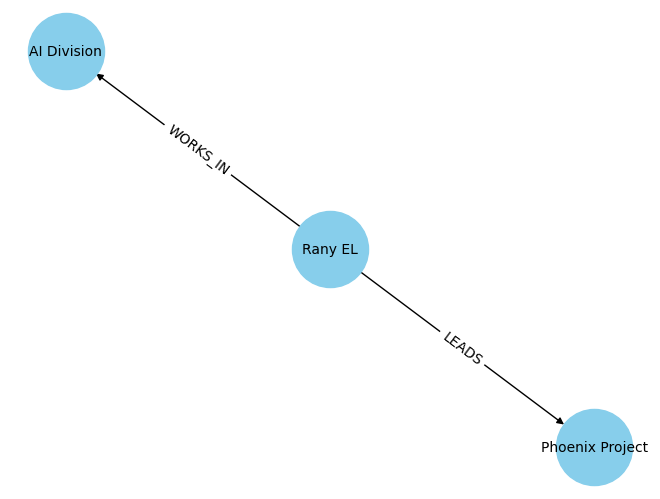

In [12]:
# You'll need to install networkx and matplotlib to visualize the graph
# pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Add nodes with properties (attributes)
G.add_node("Rany EL", type='Person', title='Senior Manager')
G.add_node("Phoenix Project", type='Project')
G.add_node("AI Division", type='Division')

# Add directed relationships (edges) between the nodes
G.add_edge("Rany EL", "Phoenix Project", label='LEADS')
G.add_edge("Rany EL", "AI Division", label='WORKS_IN')

# Now, let's do a simple visualization to see what we've built
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'label')

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

## Minimal Assistant Class (for testing)

This simple class satisfies structural tests without affecting chapter scope.

In [ ]:
class BasicAIAssistant:
    def __init__(self, model_name: str = 'text-embedding-3-small'):
        self.model_name = model_name
    def answer(self, prompt: str) -> str:
        return f'Assistant ready with model: {self.model_name}. Prompt length: {len(prompt)}'
